Adapted from learnpytorch.io


In [2]:
from sklearn.datasets import make_circles

# 1000 samples
n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=35)

In [3]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,-0.467071,-0.703847,1
1,0.049240,0.809451,1
2,-0.148359,0.841698,1
3,0.567739,-0.495415,1
4,-0.439440,-0.702983,1
5,-0.770232,-0.297929,1
6,0.440894,-0.610409,1
7,0.615815,0.794649,0
8,-0.172195,0.965688,0
9,0.152205,0.990098,0


In [4]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

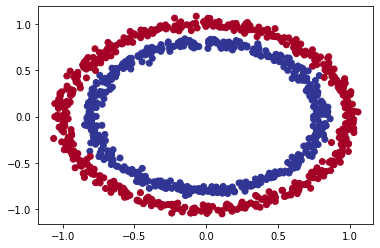

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# Goal
# 1) Turn data into tensors
# 2) Split to training and test datasets

In [8]:
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
X[:5], y[:5]

(tensor([[-0.4671, -0.7038],
         [ 0.0492,  0.8095],
         [-0.1484,  0.8417],
         [ 0.5677, -0.4954],
         [-0.4394, -0.7030]]), tensor([1., 1., 1., 1., 1.]))

In [11]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [12]:
X[:5].shape, y[:5].shape

(torch.Size([5, 2]), torch.Size([5]))

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [14]:
print(torch.__version__) # always good to document the version ran

1.13.0+cu116


In [15]:
# Standard Pytorch imports
import torch
from torch import nn

# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [34]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [35]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [36]:
# prediction time!
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.0981],
        [ 0.0137],
        [ 0.0750],
        [ 0.0111],
        [ 0.0045],
        [ 0.2928],
        [ 0.2368],
        [ 0.3205],
        [-0.0050],
        [ 0.1210]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 1.], device='cuda:0')


In [37]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [38]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [39]:
# PyTorch training loop
# 1) Forward pass
# 2) Loss calculation
# 3) Zero gradients 
# 4) Perform backpropagation on the loss
# 5) Step the optimizer (gradient descent)

In [40]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.0981],
        [0.0137],
        [0.0750],
        [0.0111],
        [0.0045]], device='cuda:0', grad_fn=<SliceBackward0>)

In [41]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5245],
        [0.5034],
        [0.5187],
        [0.5028],
        [0.5011]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [42]:
# Finding the labels
y_preds = torch.round(y_logits)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([False, False, False, False, False], device='cuda:0')


In [43]:
y_preds.squeeze()

tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [44]:
y_test[:5]

tensor([1., 1., 1., 0., 1.], device='cuda:0')

In [45]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [46]:
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1) Forward pass
  y_logits = model_0(X_train).squeeze() # squeeze to remove extra '1' dimensions
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2) Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3) optimizer zero grad
  optimizer.zero_grad()

  # 4) loss backwards
  loss.backward()

  # 5) optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}%,\
      Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69714, Accuracy: 53.00%,      Test Loss: 0.69727, Test Accuracy: 53.50%
Epoch: 10 | Loss: 0.69553, Accuracy: 51.88%,      Test Loss: 0.69516, Test Accuracy: 53.00%
Epoch: 20 | Loss: 0.69472, Accuracy: 51.25%,      Test Loss: 0.69411, Test Accuracy: 53.00%
Epoch: 30 | Loss: 0.69424, Accuracy: 51.25%,      Test Loss: 0.69356, Test Accuracy: 51.50%
Epoch: 40 | Loss: 0.69394, Accuracy: 51.12%,      Test Loss: 0.69327, Test Accuracy: 51.50%
Epoch: 50 | Loss: 0.69373, Accuracy: 50.88%,      Test Loss: 0.69312, Test Accuracy: 52.00%
Epoch: 60 | Loss: 0.69358, Accuracy: 51.00%,      Test Loss: 0.69306, Test Accuracy: 52.00%
Epoch: 70 | Loss: 0.69347, Accuracy: 51.38%,      Test Loss: 0.69305, Test Accuracy: 52.00%
Epoch: 80 | Loss: 0.69339, Accuracy: 51.50%,      Test Loss: 0.69308, Test Accuracy: 52.50%
Epoch: 90 | Loss: 0.69332, Accuracy: 51.75%,      Test Loss: 0.69312, Test Accuracy: 54.00%


In [49]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

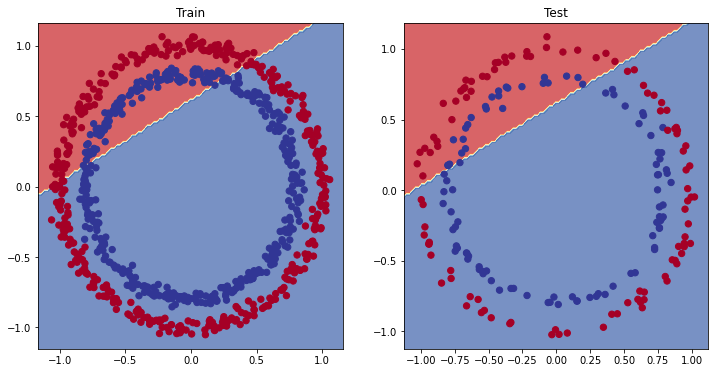

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)